In [1]:
import pandas as pd
import os
import email
import time
import csv
import sys
from sklearn.model_selection import train_test_split
import math
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
from joblib import Parallel, delayed
import multiprocessing
from sklearn.metrics.pairwise import cosine_similarity

#unique delim to separate columns without messing up content
DELIMETER = chr(255)

#needed because a few of the emails were too large for the default csv cell size
csv.field_size_limit(sys.maxsize)

#set paths (currently pathing for remote AWS EC2 Instance)
root = '/home/ubuntu/ssl/notebooks/'
testing_batch = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

In [2]:
#steps through directory and loads every email in every folder into returned df
def process_emails_into_df(origin, destination, testbool):

    #if no file already exists start the writing process
    if not os.path.isfile(destination): 

        #list for holding file paths
        list_of_files = []    

        #get the path for all the email files
        for path, subdirs, files in os.walk(origin):
            for name in files:
                list_of_files.append(os.path.join(path, name))

        email_count = len(list_of_files)
        #caluculate 1% of the number of files, used for progress report printing.
        onepcofemail = (email_count//100)

        #create dataframe to store data to be written
        emails = pd.DataFrame()
        print('Starting. {}'.format(time.strftime("%I:%M:%S")))

        #counter for testing batches
        x = 0

        #iterrate through all the files found
        for i, myfile in enumerate(list_of_files):

            #if running a testing session to break before reading all file to inspect the saved csv
            if x > 6000 and testbool: break

            #read individual email file
            with open(myfile, 'r', encoding='utf-8', errors='replace') as filepath:
                #read in the email
                message=email.message_from_string(filepath.read())

                #save the important components
                emails.loc[i,'Message-ID']=message['Message-ID']
                emails.loc[i,'from']=message['from']
                emails.loc[i,'subject']=message['subject']
                emails.loc[i,'to']=message['to']
                emails.loc[i,'cc']=message['cc']
                emails.loc[i,'bcc']=message['Bcc']
                emails.loc[i,'date']=message['date']
                emails.loc[i,'file']=message['X-FileName']

                #check that the body is one or multiple sections and save it
                if message.is_multipart():
                    string = ''
                    for payload in message.get_payload():
                        print(payload.get_payload())
                        string = string + payload.get_payload()
                        emails.loc[i,'body'] = string
                else:
                    emails.loc[i,'body'] =  message.get_payload()

            #append entry to the csv file
            with open(destination, 'a') as f:
                #if this is the first entry use the headers, if not, dont.True
                if i == 0: emails.to_csv(f, header=emails.columns, index = False, sep=DELIMETER)
                else: emails.to_csv(f, header=None, index = False, sep=DELIMETER)

            #clear the dataframe to save memory
            emails = pd.DataFrame()        

            #print statement updating progress report
            if i % onepcofemail == 0: 
                print('{}% finished. {}'.format(i//onepcofemail, time.strftime("%I:%M:%S")), end="\r")

            #itterate counter for testing batches
            x = x+1


        #process complete
        print('Done! Exported {} lines to CSV {}'.format(x, time.strftime("%I:%M:%S")))

    #prints if the file already exists and there is no need to process the individual emails into a csv
    else: 
        #open csvs of all emails
        print('**********There is already a Process CSV of All Emails, loading Now************', end="\r")
        all_emails = pd.read_csv(destination, sep=DELIMETER, engine='python')
        print('**************Processed Emails into DF Loaded From CSV, Delete File to Process Again**************')
        return all_emails        

#function that filters out non enron originating email addresses       
def filter_unwanted_senders(dataframe, new_file_dest):
    path = root + new_file_dest
    
    #check to see if file has already been processed and saved
    if not os.path.isfile(path): 
        
        #get a list of unique email senders
        unique_senders_inc_small = dataframe['from'].unique()
        
        #create an empty df to holde data
        filtered_df = pd.DataFrame(columns = dataframe.columns)
        
        #iterate through all the unique senders
        for i, sender in enumerate(unique_senders_inc_small):
            temp = dataframe[dataframe['from'] == sender]
            
            #prints progress report
            print('{}% finished filtering unwanted senders            '.format(round(i/len(
                                                                            unique_senders_inc_small)
                                                                                     *100,2)) , end="\r")

            #tests and saves senders who have enron emails
            if '@enron.com' in sender:
                filtered_df = filtered_df.append(temp, ignore_index = True)
        
        #save new list of senders
        filtered_df.to_csv(path, sep=DELIMETER, index = False)
    
    #if it has already been done don't do it again
    else: 
        print('****************Previously Filtered Senders List. Loading Old File!****************'.format(new_file_dest),
                                                                                              end="\r")
        filtered_df = pd.read_csv(path, sep=DELIMETER, engine='python')
        print('*************To Reprocess Filtered Senders Delete {}.  Loaded Old File!**************'.format(new_file_dest))
    filtered_df = filtered_df.dropna(subset = ['to', 'cc', 'bcc'], how = 'all')
    filtered_df = filtered_df.dropna(subset = ['body'])    
    return filtered_df

#makes a list of all senders and a lists all the recipients they send to in next column
def get_sender_recip_list(dataframe):
    new_file = root + 'sender_recip_df_list'
    
    if not os.path.isfile(new_file):
    
        #empty df for leading up addresses
        sender_by_recip = pd.DataFrame(columns = ['sender','recipient', 'booksize'])

        #list of unique senders
        unique_senders = dataframe['from'].unique()

        #arrays for holding values to be stored
        senders = []
        recipients = []
        addressbooksize = []

        #itterate through each unique email writer
        for i, sender in enumerate(unique_senders):

            #make a list of the samples from this itterations sender
            users_emails = dataframe[dataframe['from'] == sender]

            all_recips = users_emails['to'].tolist() + users_emails['cc'].tolist() + users_emails['bcc'].tolist() 

            if '<' in sender:
                sender = re.search('<.(.*)>', sender)
                sender = sender.group(1)
            

            namelist = []
            for l in all_recips:
                if not isinstance(l, str): pass
                else: 
                    l = l.replace('\t','').replace('\n','')
                    list_of_names = l.split(',')
                    for name in list_of_names:
                        
                        if '<' in name:
                            result = re.search('<.(.*)>', name)
                            name = result.group(1)
                            name = name.replace('"', '')
                            name = name.replace("'", '')
                            name = name.replace("..", '.')
                            name = name.strip(' ')
                            namelist.append(name)
                        
                        else:
                            name = name.replace('"', '')
                            name = name.replace("'", '')
                            name = name.strip(' ')
                            name = name.replace("..", '.')
                            namelist.append(name)
                        


            #name = [item for sublist in name for item in sublist]
            unique_recips = list(set(namelist))
            for name in unique_recips:
                recipients.append(name)
                senders.append(sender)
                addressbooksize.append(len(unique_recips))
            

            print('{}% of sender + recip dataframe completed        '.format(
                                                                        round(i/len(unique_senders)*100,2))
                                                                        , end="\r")

        sender_by_recip['sender'] = senders
        sender_by_recip['recipient'] = recipients
        sender_by_recip['booksize'] = addressbooksize
        print('********************* Sender Recip Dataframe Completed ******************')
        sender_by_recip.to_csv(new_file, sep=DELIMETER, index = False)
        return sender_by_recip
    else:
        print('********************* Sender Recip Already Processed ********************', end="\r")
        sender_by_recip = pd.read_csv(new_file, sep=DELIMETER, engine = 'python')
        print('******************* Sender Recip Dataframe with Lists CSV Loaded ******************')
        return sender_by_recip


def remove_strang_problematic_addesses(s_r_pair_list):
    
    #this one was VERY problematic to parse, maybe best to skip this sender
    s_r_pair_list = s_r_pair_list[s_r_pair_list['sender'] != 'enron.announcements@enron.com']
    
    s_r_pair_list = s_r_pair_list[s_r_pair_list['sender'] != '40enron@enron.com']

    
    #there were some junk addresses that were clearly just in error, lets drop those
    bad_index = s_r_pair_list[s_r_pair_list['recipient'].str.contains('@enron@enron.com')].index

    #do the actual dropping
    s_r_pair_list.drop(bad_index, inplace = True)
    del bad_index
    
    #there were some junk addresses that were clearly just in error, lets drop those
    bad_index = s_r_pair_list[s_r_pair_list['recipient'].str.contains('/')].index

    #do the actual dropping
    s_r_pair_list.drop(bad_index, inplace = True)
    del bad_index
    
    #there were some junk addresses that were clearly just in error, lets drop those
    bad_index = s_r_pair_list[s_r_pair_list['recipient'].str.contains('&')].index

    #do the actual dropping
    s_r_pair_list.drop(bad_index, inplace = True)
    del bad_index
    
    #there were some junk addresses that were clearly just in error, lets drop those
    bad_index = s_r_pair_list[s_r_pair_list['recipient'] == '<'].index

    #do the actual dropping
    s_r_pair_list.drop(bad_index, inplace = True)
    del bad_index
    
    #get rid of peoples typos sending to @enron.com
    s_r_pair_list = s_r_pair_list[s_r_pair_list['recipient'] != '@enron.com']
    
    #reset index values after removing elements from the process
    s_r_pair_list.index = range(len(s_r_pair_list.index))
    
    return s_r_pair_list

def email_exchange_count(pair_list, emails):
    new_list = pd.DataFrame()
    new_file = root + 'emailcountsadded'
    
    senders = []
    recipient = []
    addressbook = []
    numemails = []
    
    if not os.path.isfile(new_file):
        for index, row in pair_list.iterrows():
                #current sender
                from_ = row['sender']
                #current recipient
                to_ = row['recipient']

                #select all email bodies from and to current selection
                combo_s_r = emails[(emails['from']== from_) & (to_ in emails['to_all'])]['body']
                
                senders.append(from_)
                recipient.append(to_)
                addressbook.append(row['booksize'])
                numemails.append(len(combo_s_r))
                
                if(index%(round(len(pair_list)/10000,0)) == 0):
                    print('{}% done Time: {}                            '.format((round(index/
                                                                    len(pair_list),4)*100),
                                                                    time.strftime("%I:%M:%S")), end="\r")
        
        new_list['sender'] = senders
        new_list['recipient'] = recipient
        new_list['addressbooksize'] = addressbook
        new_list['num_emails'] = numemails

        
        new_list.to_csv(new_file, sep=DELIMETER, index = False)
        return new_list
    
    else:
        
        #let user know process was previously completed and open previously processed file
        print('Counts were previously calculated.  Opening saved File', end = '\r')
        new_list = pd.read_csv(new_file, sep=DELIMETER, engine = 'python')
        print('*************************EmailCounts  file Opened **************************')
        return new_list    
    
    
def calc_pred_accuracy(sr_list, emails):
    new_file = root + 'sr_pred_acc'
    if not os.path.isfile(new_file):
        sr_list['centroid'] = sr_list['centroid'].astype('object')
        smallerlistscores = []
        for i, sender in enumerate(sr_list['sender'].unique()):
            for index, reciever in sr_list[sr_list['sender'] == sender].iterrows():
                from_ = sender
                to_ = reciever['recipient']


                senders_emails = emails[(emails['from']== from_)]

                x = tfidfv.fit_transform(senders_emails['body']).toarray()
                senders_emails['tf_idf'] = list(x)

                X_train, X_test = train_test_split(senders_emails, test_size = 0.25)

                pairs_emails = senders_emails[(senders_emails['from']== from_) & ((senders_emails['to_all'].str.contains(to_)))]
                #compute the centroid of the pairs emails
                Y = pairs_emails['tf_idf'].tolist()
                centroid_list = [list(i/np.sum(i)) for i in Y]
                centroid = [sum(x) for x in zip(*centroid_list)]
                centroid = [0 if math.isnan(x) else x for x in centroid]

                #save the centroid to the pairs list
                sr_list['centroid'][index] = centroid

                #calcuate centroid similarity to all test emails
                similarities = []
                for index, email in X_test.iterrows():
                    similarities.append(cosine_similarity(centroid, email['tf_idf']))
                X_test['similarities'] = similarities

                score = []
                #if the similarity score is above threshhold assume they are similar and score results
                for index2, email in X_test[X_test['similarities']>0.5].iterrows():
                    if to_ in email.to_all:
                        score.append(1)
                    else:
                        score.append(0)
                score = np.mean(score)

                smallerlistscores.append(score)


                precent_done = round(i/sr_list['sender'].nunique()*100, 4)
                print(precent_done, '%', sender, reciever['recipient'],score,  '                  ', end = '\r')

        sr_list['accuracy'] = smallerlistscores
        print('*********Saving accuracy scores file *******************', end = '\r')
        sr_list.to_csv(new_file, sep=DELIMETER, index = False)
        print('****************Accuracy scores file saved *******************')
        return sr_list
    else:
       #let user know process was previously completed and open previously processed file
        print('***********Accuracies were previously calculated.  Opening saved File********', end = '\r')
        sr_list = pd.read_csv(new_file, sep=DELIMETER, engine = 'python')
        print('******************Accuracy scores file Opened *******************************')
        return sr_list  

In [3]:
#read in all files to process emails into dataframe
all_emails = process_emails_into_df(root + 'data/maildir', root + 'processed enron emails.csv', testing_batch)

#filter out the non enron email senders
wanted_emails = filter_unwanted_senders(all_emails, 'small_senders_filtered')

wanted_emails['to'] = wanted_emails['to'].fillna(' ')
wanted_emails['cc'] = wanted_emails['cc'].fillna(' ')
wanted_emails['bcc'] = wanted_emails['bcc'].fillna(' ')

wanted_emails['to_all'] = wanted_emails['to'] + wanted_emails['cc'] + wanted_emails['bcc']

#compile a dataframe of all senders and all unique recipients to that sender
senders_reciever_list = get_sender_recip_list(wanted_emails)

#some final cleaning of addresses that cause problems or that are clearly just junk
clean_pair_list = remove_strang_problematic_addesses(senders_reciever_list)

#count the number of emails sent from each sender to each recipient
email_counts_added = email_exchange_count(clean_pair_list, wanted_emails)

smaller_sr_list = email_counts_added[email_counts_added['num_emails'] > 50]

smaller_sr_list = smaller_sr_list[smaller_sr_list['sender']!='outlook.team@enron.com']

pred_acc_sr_list = calc_pred_accuracy(smaller_sr_list, wanted_emails)

**************Processed Emails into DF Loaded From CSV, Delete File to Process Again**************
*************To Reprocess Filtered Senders Delete small_senders_filtered.  Loaded Old File!**************
******************* Sender Recip Dataframe with Lists CSV Loaded ******************
*************************EmailCounts  file Opened **************************
******************Accuracy scores file Opened *******************************


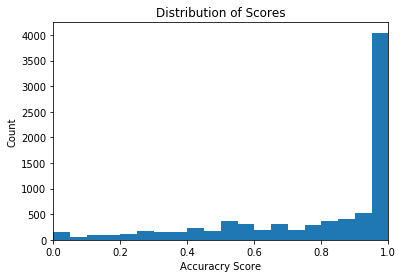

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
pred_acc_sr_list.dropna(subset = ['accuracy'], inplace = True)
plt.hist(pred_acc_sr_list['accuracy'], bins = 20)
plt.xlabel('Accuracry Score')
plt.ylabel('Count')
plt.xlim(0,1)
plt.title('Distribution of Scores')
plt.show()

In [23]:
pred_acc_sr_list['accuracy'].mean()

0.79173712044647504

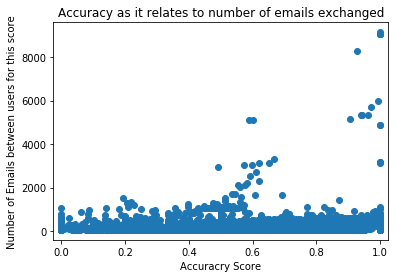

In [10]:
plt.scatter(pred_acc_sr_list['accuracy'], pred_acc_sr_list['num_emails'])
plt.xlabel('Accuracry Score')
plt.ylabel('Number of Emails between users for this score')
plt.title('Accuracy as it relates to number of emails exchanged')
plt.xlim(-0.025,1.025)
plt.show()

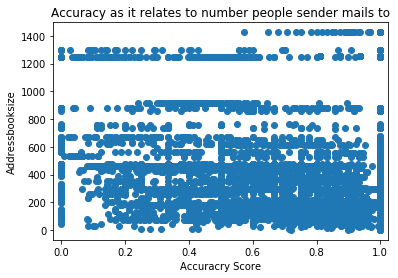

In [11]:
plt.scatter(pred_acc_sr_list['accuracy'], pred_acc_sr_list['addressbooksize'])
plt.xlabel('Accuracry Score')
plt.ylabel('Addressbooksize')
plt.title('Accuracy as it relates to number people sender mails to')
plt.xlim(-0.025,1.025)
plt.show()

In [12]:
sender_avg_scores = pred_acc_sr_list.groupby('sender').mean()

In [13]:
sender_avg_scores[sender_avg_scores['accuracy'] == sender_avg_scores['accuracy'].min()]

,addressbooksize,num_emails,score,accuracy
sender,,,,
laura.luce@enron.com,66.0,57.0,0.0,0.0


In [19]:
pred_acc_sr_list[pred_acc_sr_list['sender'] == 'laura.luce@enron.com']

,sender,recipient,addressbooksize,num_emails,centroid,score,accuracy
5344,laura.luce@enron.com,louise.kitchen@enron.com,66,57,"[0.045617860878014289, 0.090159315878670099, 0...",0,0.0
